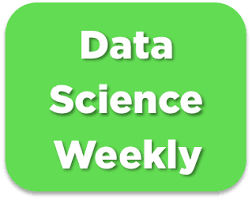

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

/Users/lamothemarjory/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lamothemarjory/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/lamothemarjory/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/lamothemarjory/opt/anaconda3/lib/python3.8/site-packages/dask/datafr

# Read file with labels

In [2]:
df = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', df.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])


Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

# Explore dataset

In [4]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = df.sample(10000)

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [5]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "converted"

X = df.drop(target_variable, axis = 1)
Y = df.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


In [6]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)


Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


/var/folders/xb/drv26b894gdfny25v9m1mw040000gn/T/ipykernel_7954/1492302125.py:4: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [7]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [8]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Preprocessing on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
137434   China   19         1     Seo                    1
112323      US   33         1  Direct                    5
143261      US   51         1     Ads                    2
162328   China   17         0     Seo                    1
158039   China   28         1     Seo                    5
...Done.
[[-1.3990984   0.67651656 -1.15935344  0.          0.          0.
   0.          1.        ]
 [ 0.29299544  0.67651656  0.03743241  0.          0.          1.
   1.          0.        ]
 [ 2.46854467  0.67651656 -0.86015697  0.          0.          1.
   0.          0.        ]
 [-1.64082609 -1.47816042 -1.15935344  0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.67651656  0.03743241  0.          0.          0.
   0.          1.        ]]

Encoding labels...
137434    0
112323    0
143261    0
162328    0
158039    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]

/var/folders/xb/drv26b894gdfny25v9m1mw040000gn/T/ipykernel_7954/1691135953.py:43: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [9]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = BaggingClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__max_depth': [1, 2, 3], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'n_estimators': 2}
Best validation accuracy :  0.9845430107526881

Accuracy on training set :  0.9845430107526881
Accuracy on test set :  0.9842047930283224


In [10]:
print("Predictions on train set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on train set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.99706659 0.00293341]
 [0.99706659 0.00293341]
 [0.99706659 0.00293341]
 ...
 [0.99706659 0.00293341]
 [0.97863235 0.02136765]
 [0.99706659 0.00293341]]



## Test pipeline

In [11]:
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.99706659 0.00293341]
 [0.99706659 0.00293341]
 [0.99706659 0.00293341]
 ...
 [0.99706659 0.00293341]
 [0.99706659 0.00293341]
 [0.99706659 0.00293341]]



In [12]:
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9845430107526881
accuracy on test set :  0.9842047930283224

f1-score on training set :  0.7292452104331768
f1-score on test set :  0.722616476396174



## Performance assessment

In [13]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__max_depth': [1, 2, 3], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 2, 'n_estimators': 10}
Best validation accuracy :  0.9860056925996205

Accuracy on training set :  0.9858519572703633
Accuracy on test set :  0.9853468269028042


In [22]:
# Perform grid search
print("Grid search...")
model = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    'max_depth': [1, 2, 3], # no base_estimator_ prefix because these are all arguments of GradientBoostingClassifier
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Done.
Best hyperparameters :  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best validation accuracy :  0.9842487174081102

Accuracy on training set :  0.9847406704617331
Accuracy on test set :  0.984292641787898


In [15]:
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219406    914]
 [  2605   4739]]

Confusion matrix on test set : 
[[54846   234]
 [  665  1171]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [16]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearch.fit(X,Y)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [2, 4, 6, 8, 10]})

In [17]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]


Prediction set (without labels) : (31620, 5)


In [18]:
numeric_features = []
categorical_features = []
for i,t in X_without_labels.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


/var/folders/xb/drv26b894gdfny25v9m1mw040000gn/T/ipykernel_7954/4161672073.py:3: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [19]:
# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_without_labels.head()) 
X_without_labels = preprocessor.transform(X_without_labels) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_without_labels[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on test set...
  country  age  new_user  source  total_pages_visited
0      UK   28         0     Seo                   16
1      UK   22         1  Direct                    5
2   China   32         1     Seo                    1
3      US   32         1     Ads                    6
4   China   25         0     Seo                    3
...Done.
[[-0.31132378 -1.47816042  3.3285935   0.          1.          0.
   0.          1.        ]
 [-1.03650686  0.67651656  0.03743241  0.          1.          0.
   1.          0.        ]
 [ 0.1721316   0.67651656 -1.15935344  0.          0.          0.
   0.          1.        ]
 [ 0.1721316   0.67651656  0.33662888  0.          0.          1.
   0.          0.        ]
 [-0.67391532 -1.47816042 -0.56096051  0.          0.          0.
   0.          1.        ]]



In [20]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = pd.DataFrame(X_without_labels)
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Convert pandas DataFrames to numpy arrays...
...Done
[[-0.31132378 -1.47816042  3.3285935   0.          1.          0.
   0.          1.        ]
 [-1.03650686  0.67651656  0.03743241  0.          1.          0.
   1.          0.        ]
 [ 0.1721316   0.67651656 -1.15935344  0.          0.          0.
   0.          1.        ]
 [ 0.1721316   0.67651656  0.33662888  0.          0.          1.
   0.          0.        ]
 [-0.67391532 -1.47816042 -0.56096051  0.          0.          0.
   0.          1.        ]]


In [26]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
classifier_1 = GradientBoostingClassifier(max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10)
classifier_1.fit(X_train, Y_train)
data = {
    'converted': classifier_1.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_MARJORY-Adaboost_RF.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**